In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import LocalCluster, Client

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter, temporal_train_test_split
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.arima import AutoARIMA
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, MeanAbsoluteScaledError, mean_absolute_scaled_error

SEED=0
np.random.seed(SEED)

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [6]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [7]:
forecasting_horizon = 12
fh = list(range(1, forecasting_horizon+1))

window_lengths = [24, 36, 48, 72]
step_size = 1

In [12]:
def load_and_preprocess_daily_data_arima(start_index, end_index):
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="M", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[1], freq="M", start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
    co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")

    contamination = 0.01
    esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)

    y = pd.Series(esios_spot)

    y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=forecasting_horizon)

    return y_train, y_test, X_train, X_test

## Postpandemic

### 6 months dataset

In [13]:
y_train, y_test, X_train, X_test = load_and_preprocess_daily_data_arima(start_index="2014-01", end_index="2023-03")

In [14]:
cv_results_df = func.crossval_arima_sktime(y_train, X_train, window_lengths, step_size, fh, save_path="lab/models/monthly/", save_name="arima_9y_10w_1step_12fh_6pred_mase.pkl")

Training setup: regressor AutoARIMA_24


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood o

Training setup: regressor AutoARIMA_36


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Chec

Training setup: regressor AutoARIMA_48


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Chec

Training setup: regressor AutoARIMA_72


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Chec

In [15]:
save_path = "lab/models/monthly/"
cv_results_df = pd.read_pickle(save_path+"arima_9y_10w_1step_12fh_6pred_mase.pkl")

In [16]:
cv_results_df_summary = func.crossval_summary_sktime(cv_results_df)
cv_results_df_summary

,model,mae,mase,fit_time
2,AutoARIMA_48,364.319399,1.776982,114.29715
1,AutoARIMA_36,547.017752,2.023715,124.680216
0,AutoARIMA_24,676.58178,2.046998,68.49768
3,AutoARIMA_72,202.736753,2.445332,67.781334


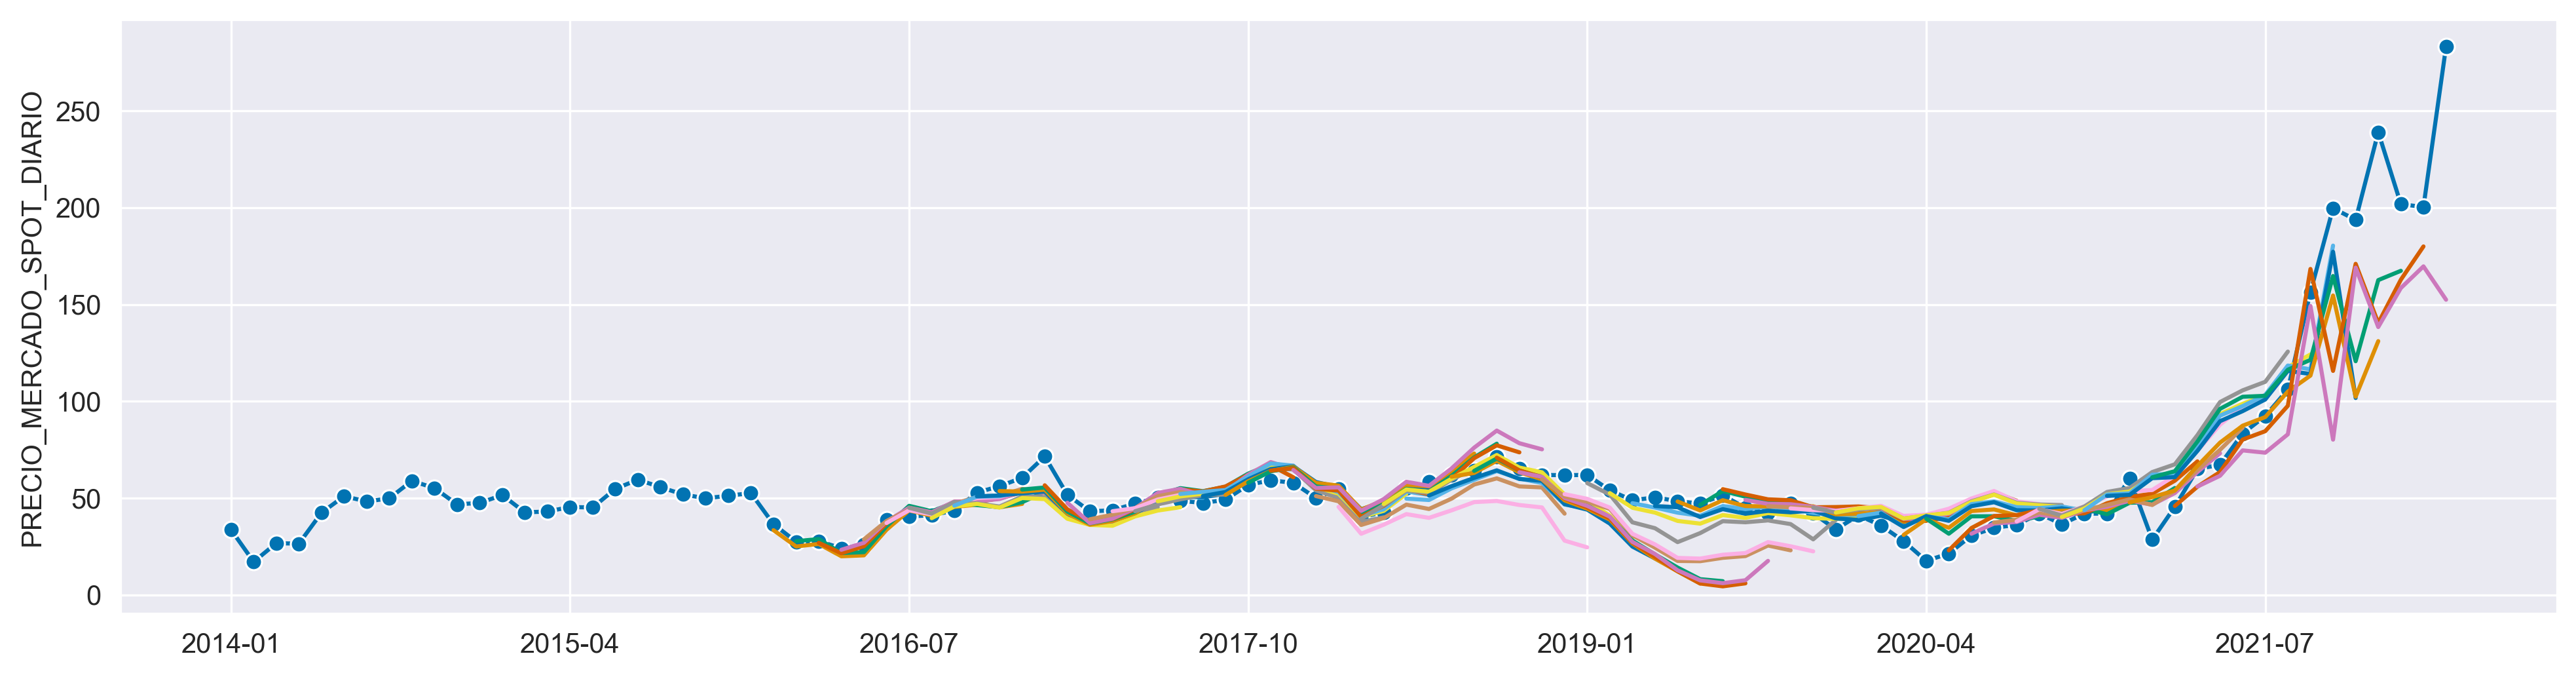

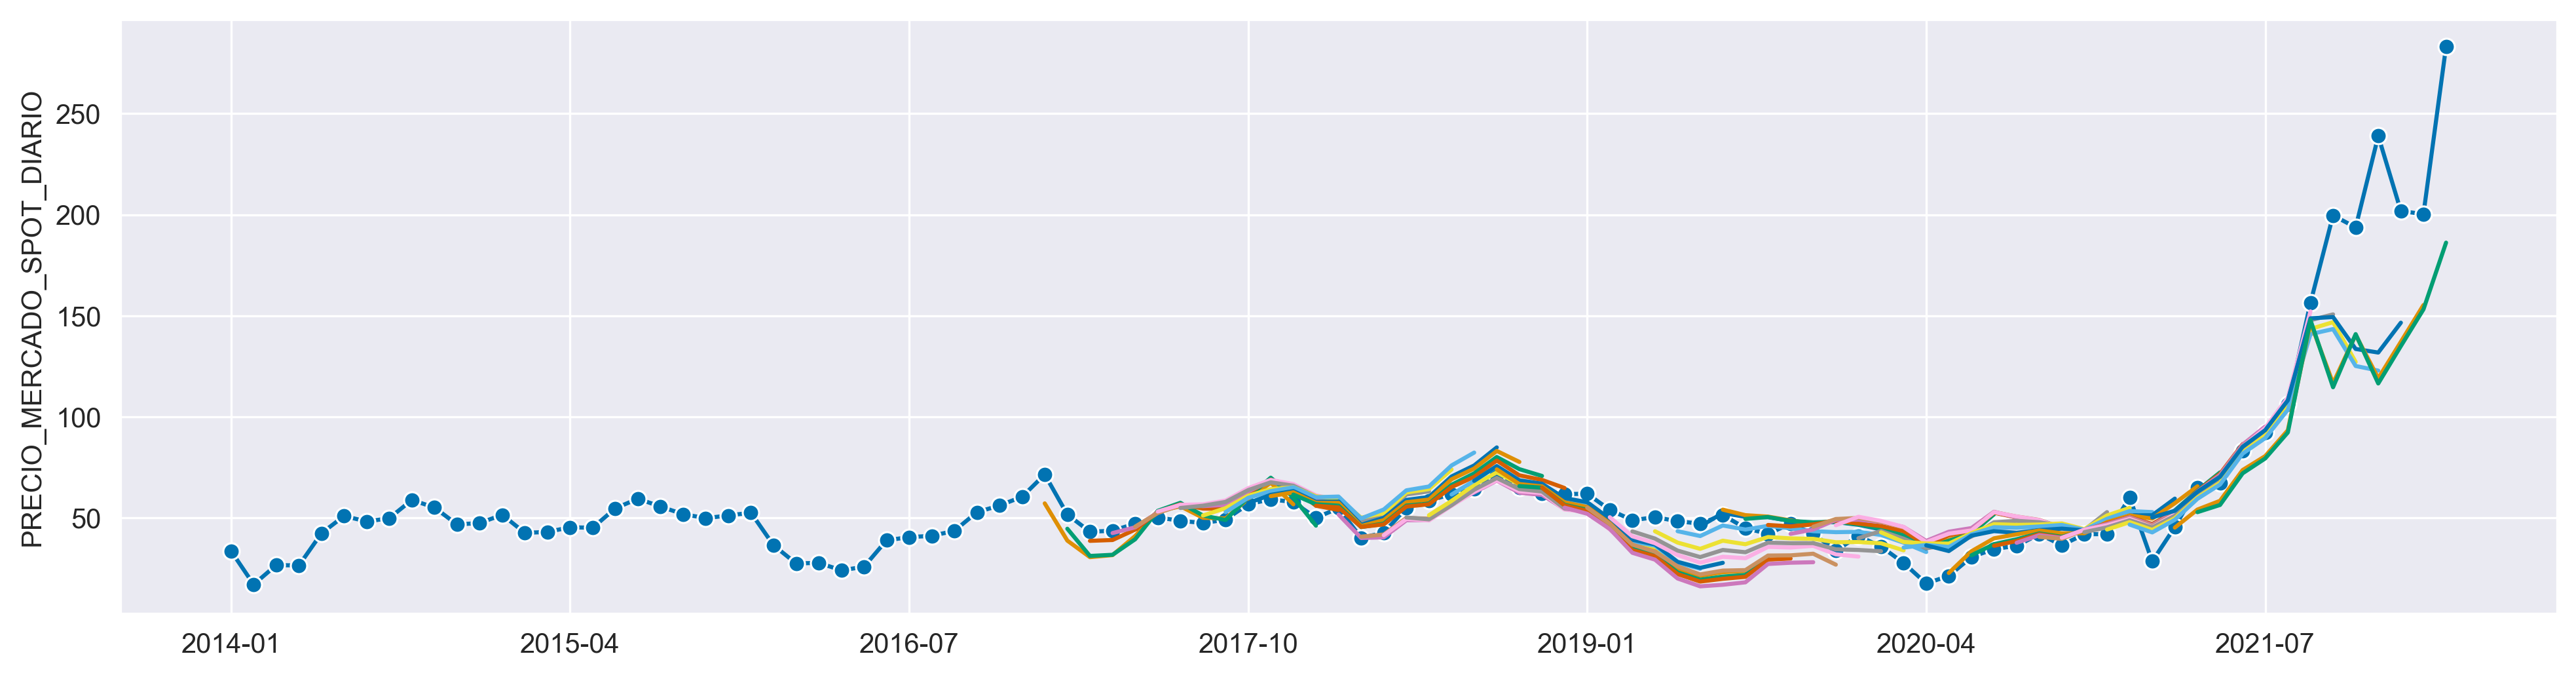

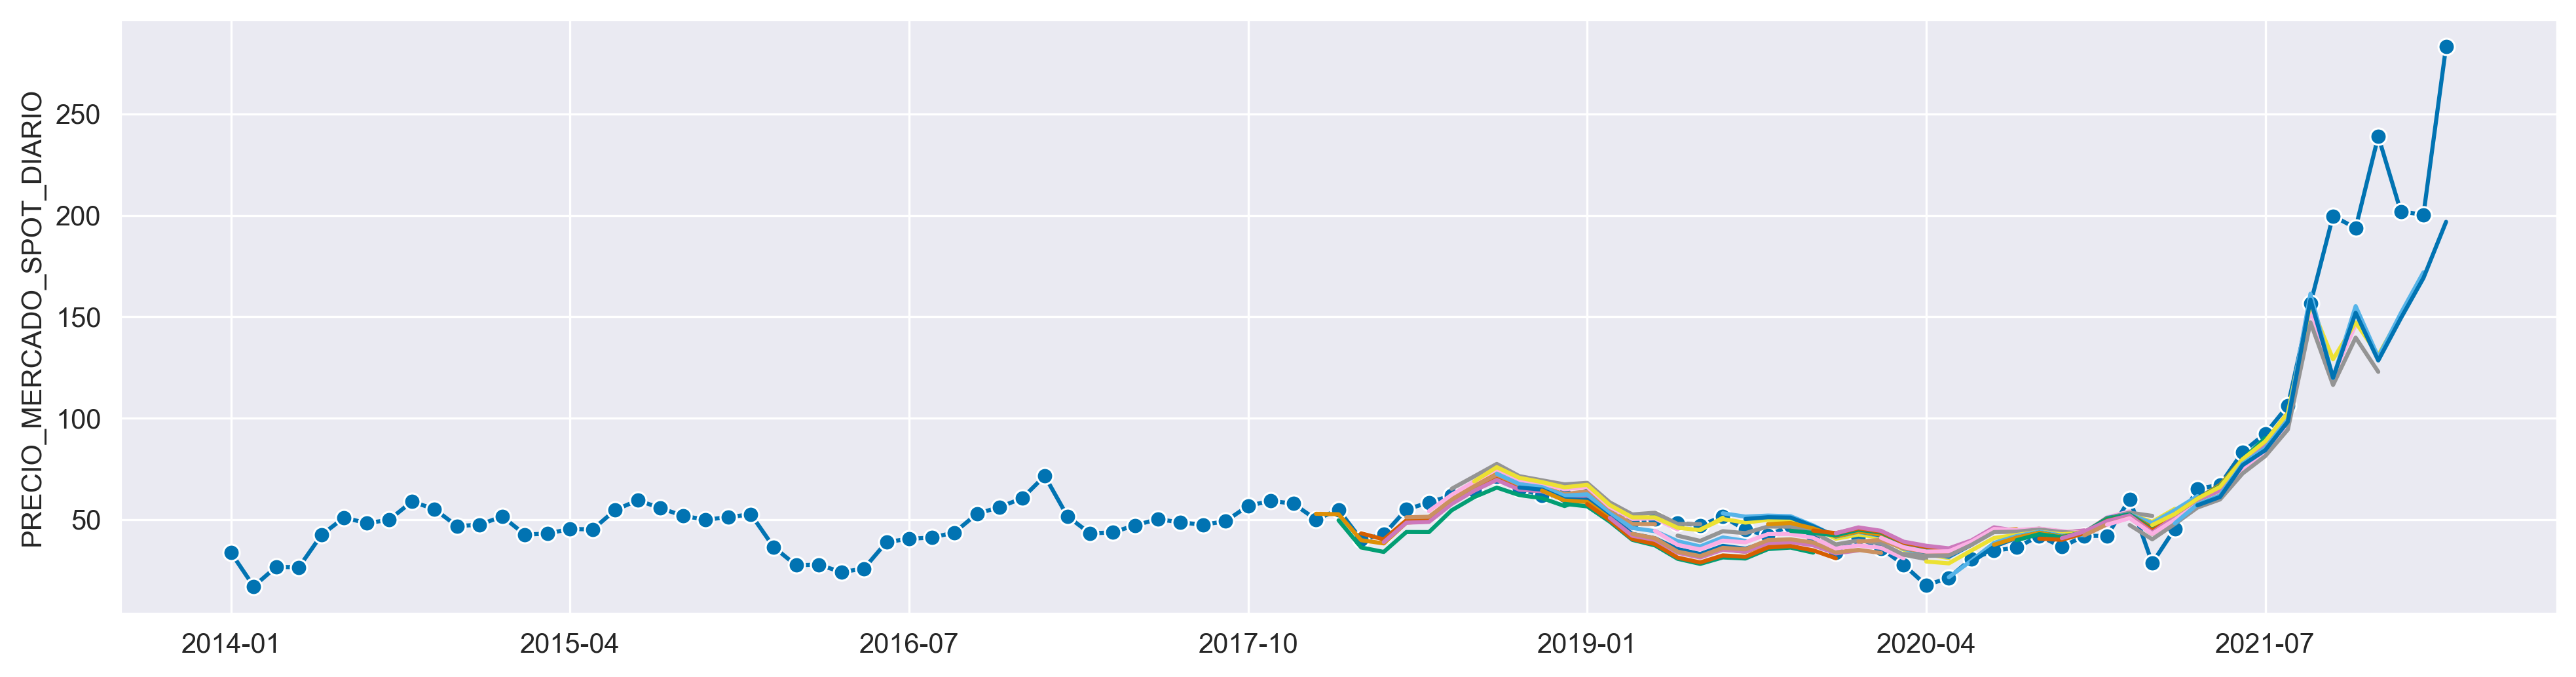

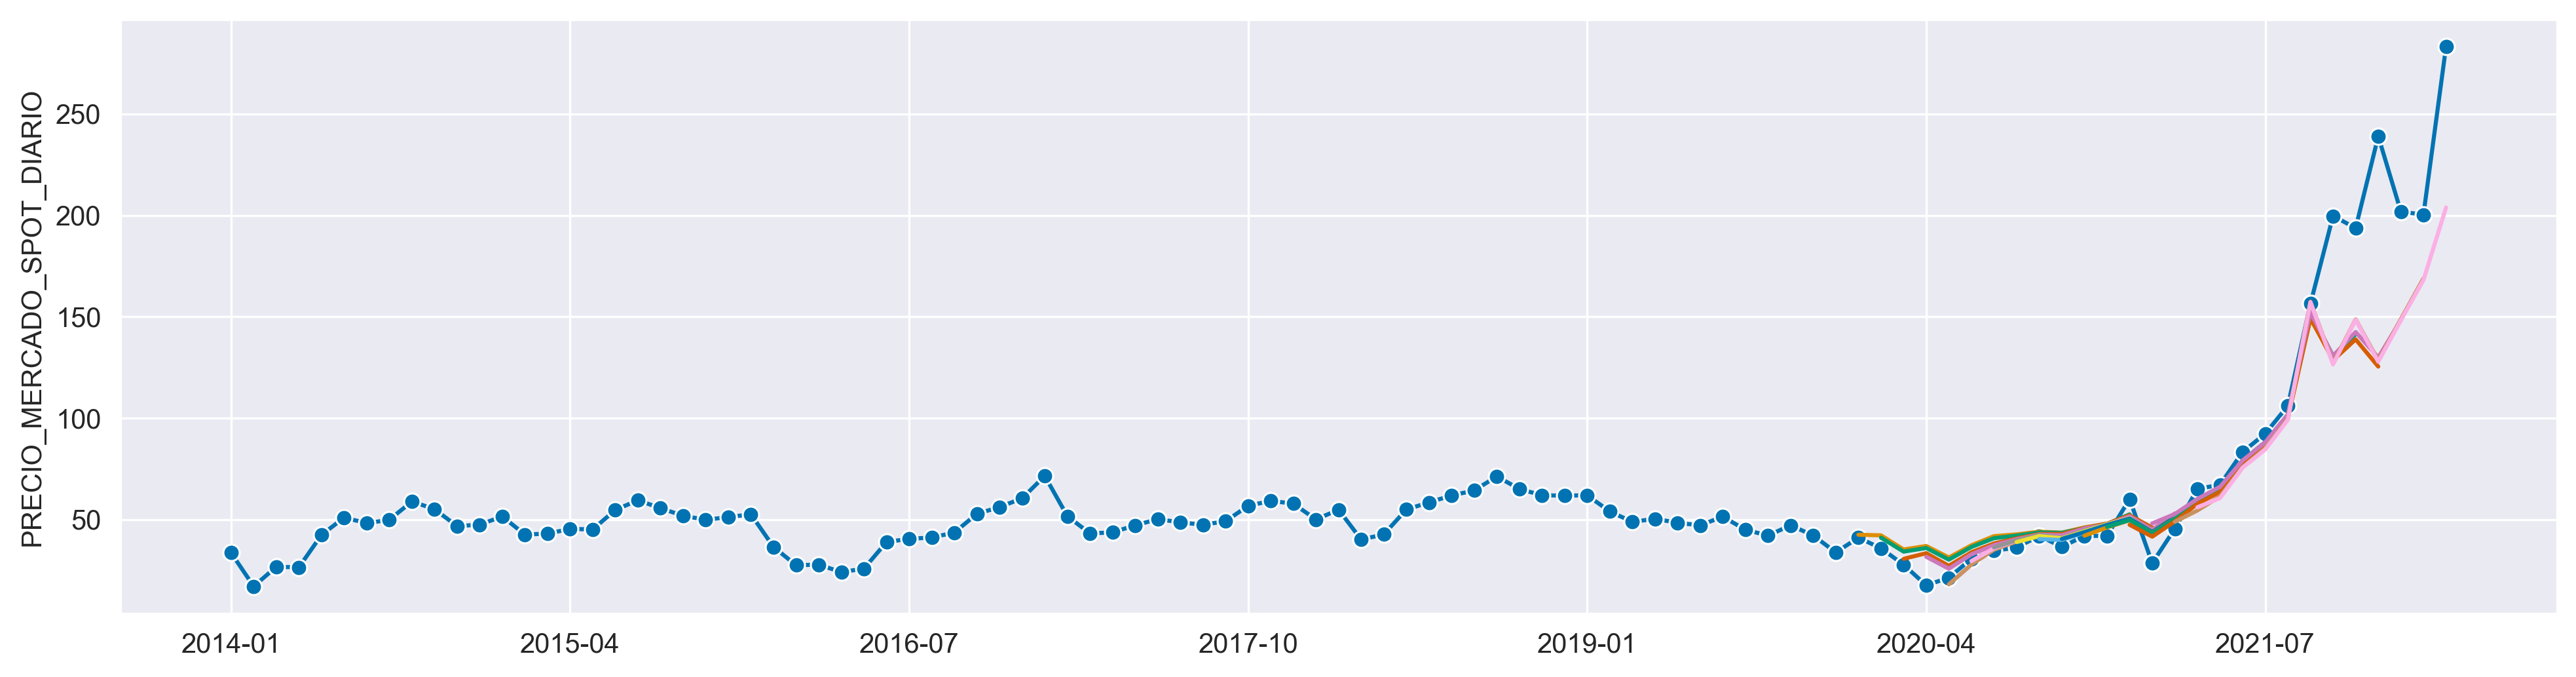

In [17]:
func.crossval_plot_series(y_train, cv_results_df)

#### Final model

Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
Maximum Likelihood optimization failed to converge. Check mle_retvals
divide by zero encountered in reciprocal
divide by zero encountered in reciprocal
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to co

120.0444120485347
0.9344726839531586
10.537185892642238


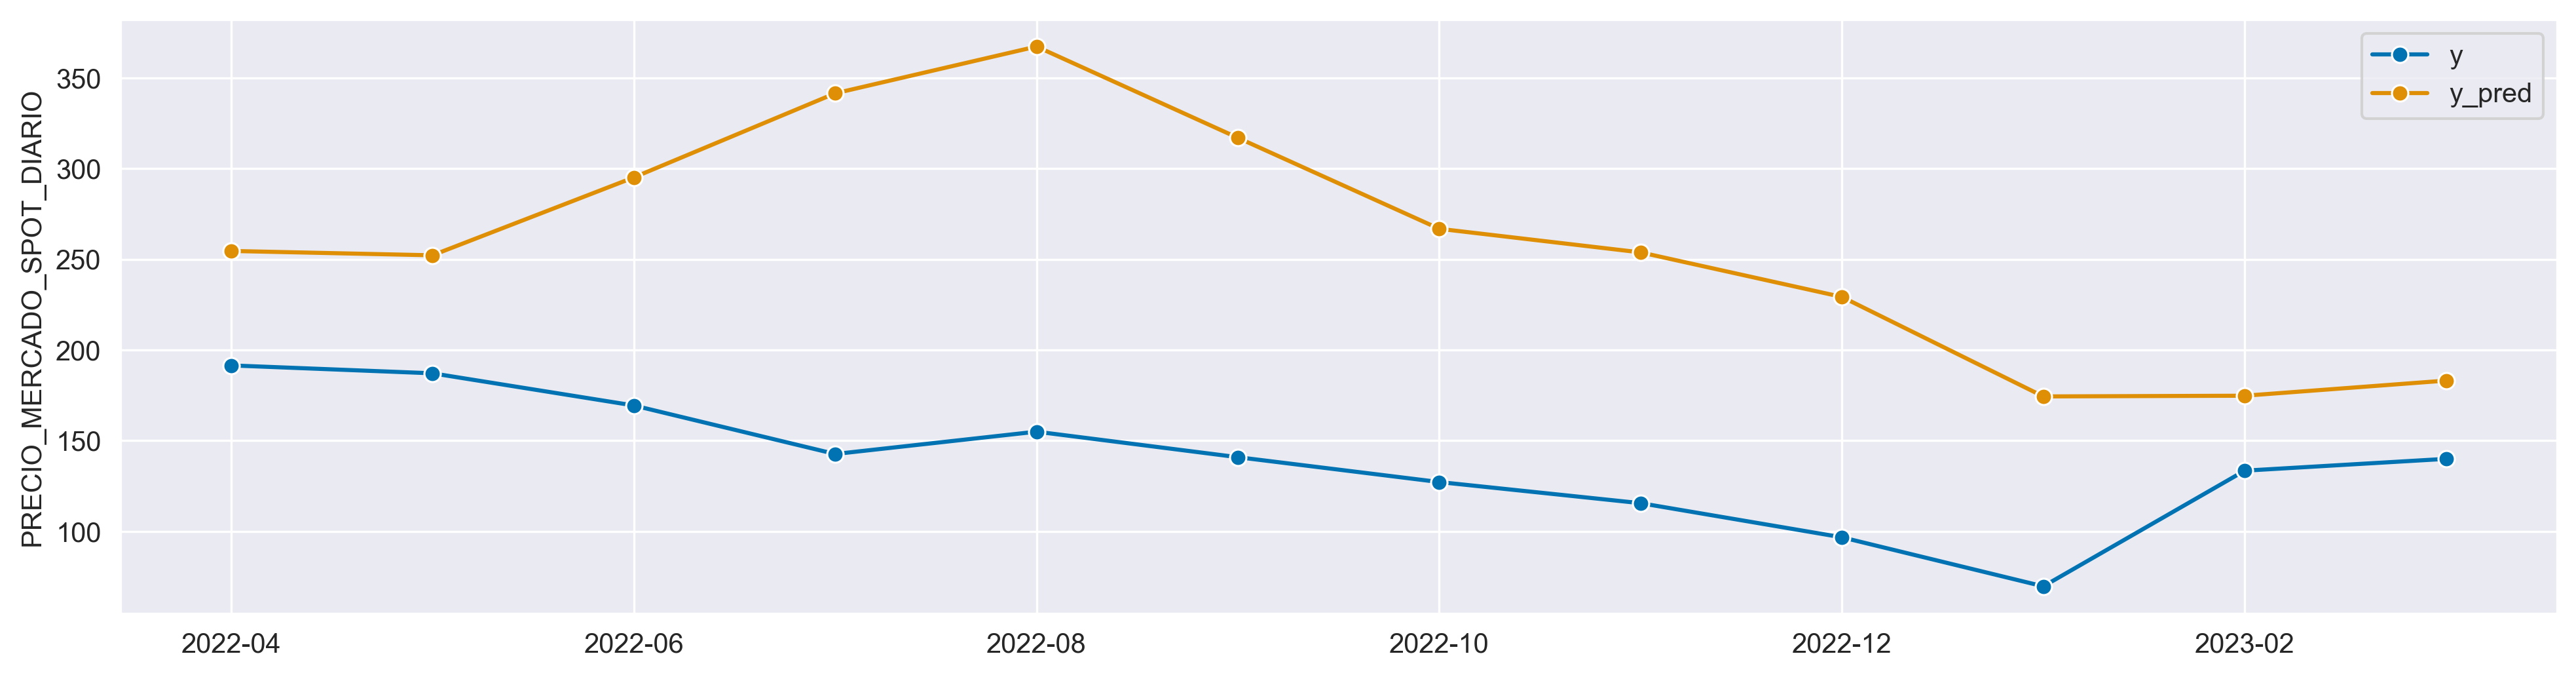

In [18]:
best_window_length = int(cv_results_df_summary.iloc[0, 0].split("_")[1])
forecaster = AutoARIMA(maxiter=200)
forecaster.fit(y_train[best_window_length:], X=X_train, )

y_pred = forecaster.predict(X=X_test, fh=list(range(1, forecasting_horizon + 1)))
plot_series(y_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_scaled_error(y_test, y_pred, y_train=y_train[best_window_length:]))

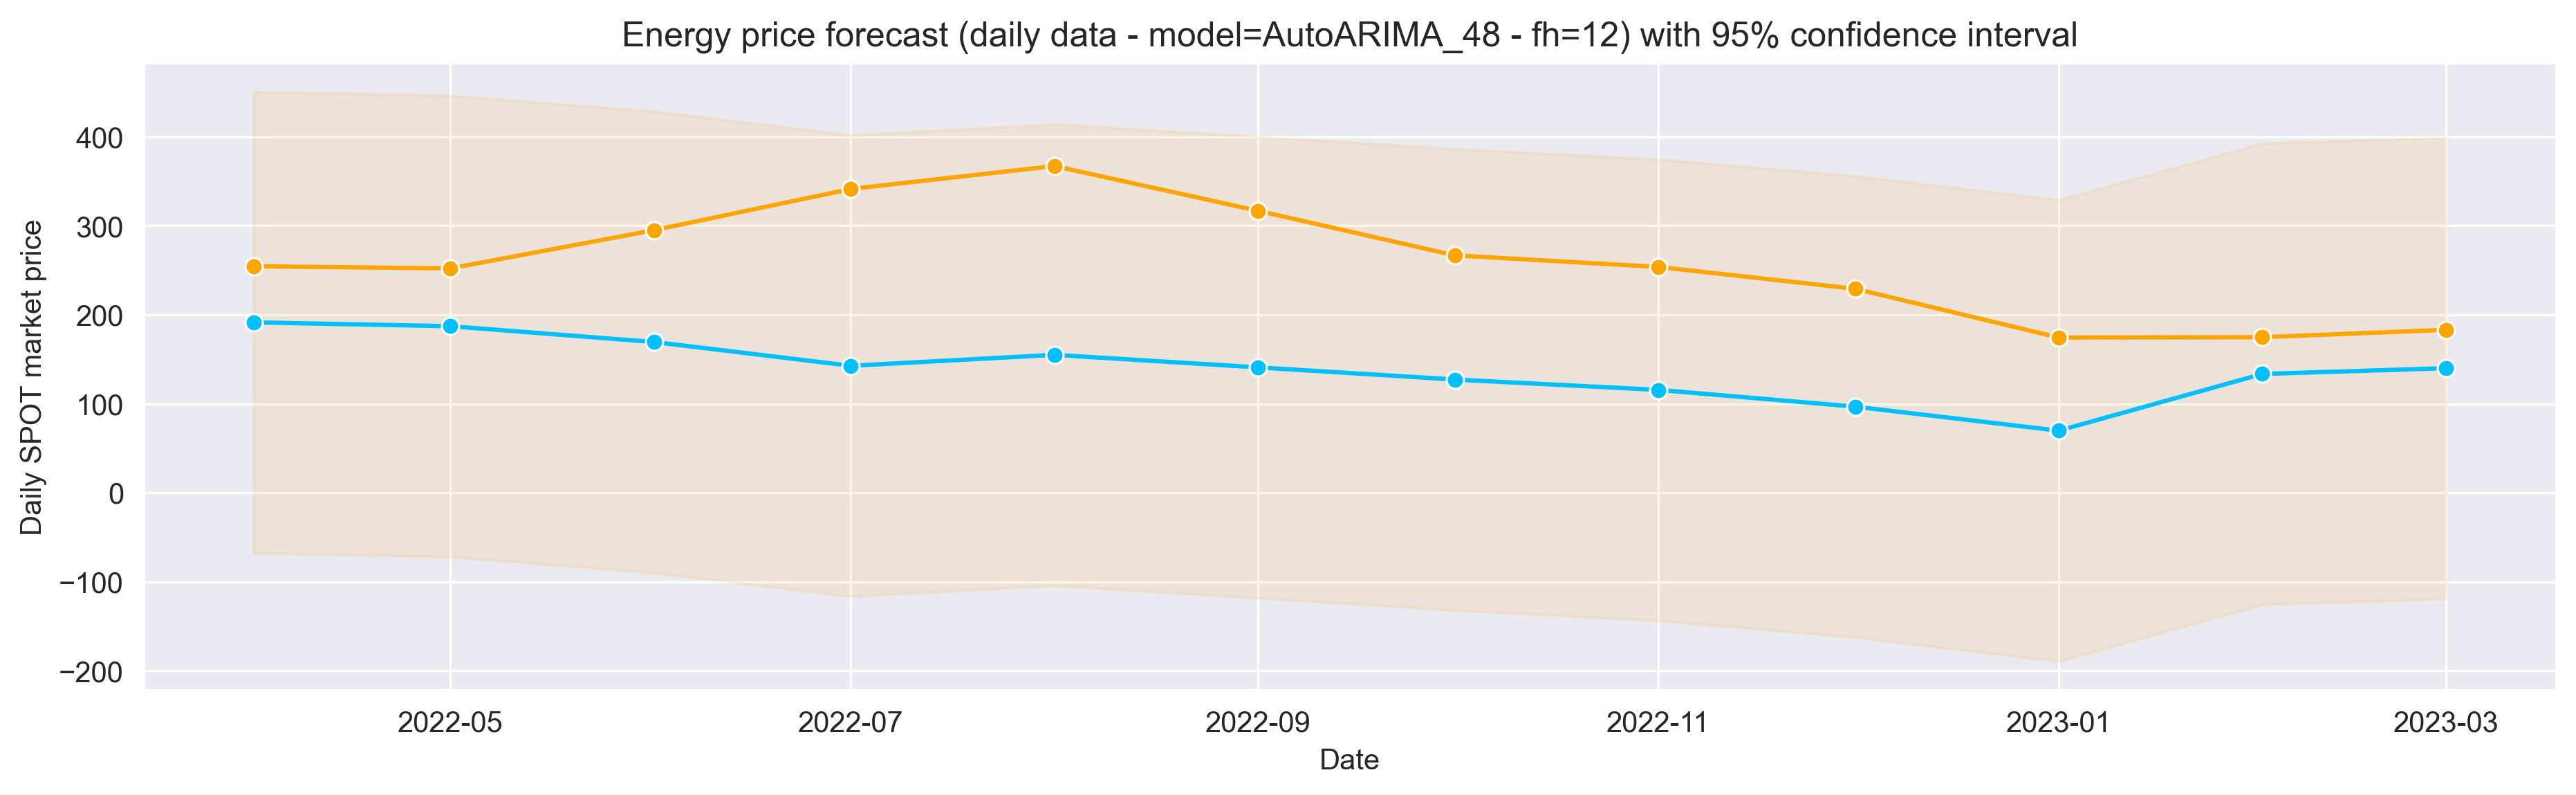

In [19]:
residuals = list(abs(y_pred-y_test))
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_test.index) is pd.core.indexes.period.PeriodIndex:
    y_test.index = y_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=y_test, color="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, color="orange", marker="o", ax=ax)
ax.fill_between(y_test.index, (y_test-band_size), (y_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - model=AutoARIMA_{best_window_length} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
plt.show()

In [20]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -196.595
Date:                Sun, 25 Jun 2023   AIC                            417.189
Time:                        16:39:44   BIC                            440.371
Sample:                    01-31-2018   HQIC                           426.048
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
DEMANDA_REAL                      -1.959e-07   3.59e-06     -0.055      0.957   -7.24e-06    6.84e-06
GENERACIÓN_MEDIDA_EÓLICA           1.445e-06   3.98e-06      0.363      0.716   -6.35e-06    9.24e-06
GENERACIÓN_MEDIDA_HIDRÁULICA       -5.08e-07    5.3e-06     -0.096      0.924   -1.09e-05    9.87e-06
GENERACIÓN_MEDIDA_NUCLEAR         -7.271e-06   6.71e-06     -1.084      0.278   -2.04e-05    5.88e-06
GENERACIÓN_MEDIDA_SOLAR           -9.994e-06   8.37e-06     -1.194      0.232   -2.64e-05    6.41e-06
GENERACIÓN_MEDIDA_CICLO_COMBINADO  5.093e-06   4.98e-06      1.022      0.307   -4.67e-06    1.49e-05
GENERACIÓN_MEDIDA_CARBÓN            5.24e-06   5.79e-06      0.905      0.366   -6.11e-06    1.66e-05
MONTHLY_TTF_PRICE                     0.5347      0.168      3.181      0.001       0.205       0.864
DAILY_COAL_PRICE                      0.4297      0.088      4.895      0.000       0.258       0.602
CO2_EUA_PRICE                         1.3519      0.229      5.906      0.000       0.903       1.800
ar.L1                                 0.3334      0.244      1.366      0.172      -0.145       0.812
sigma2                              132.7933      0.002   7.65e+04      0.000     132.790     132.797
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                48.92
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.54   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+20. Standard errors may be unstable.
"""